In [1]:
%cd E:\kaggle\iceberg

E:\kaggle\iceberg


In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from os.path import join as opj
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

import sys
batch_size=64
if sys.version_info[1] <= 5:# for my laptop pc, poor gpu memory
    batch_size=32
    from keras.backend.tensorflow_backend import set_session  
    config = tf.ConfigProto()  
    config.gpu_options.allow_growth = True
#     config.gpu_options.per_process_gpu_memory_fraction = 0.9
    set_session(tf.Session(config=config)) 

Using TensorFlow backend.


In [3]:
def display_img(band_1, band_2, is_iceberg, angle = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(angle) if is_iceberg == 1 else 'Ship-' + str(angle)
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()

# implement functions to convert SAR data from decibel units to linear units and back again
def decibel_to_linear(band):
     # convert to linear units
    return np.power(10,np.array(band)/10)

def linear_to_decibel(band):
    return 10*np.log10(band)

# implement the Lee Filter for a band in an image already reshaped into the proper dimensions
def lee_filter(band, window, var_noise = 0.25):
    # band: SAR data to be despeckled (already reshaped into image dimensions)
    # window: descpeckling filter window (tuple)
    # default noise variance = 0.25
    # assumes noise mean = 0
    
    mean_window = uniform_filter(band, window)
    mean_sqr_window = uniform_filter(band**2, window)
    var_window = mean_sqr_window - mean_window**2

    weights = var_window / (var_window + var_noise)
    band_filtered = mean_window + weights*(band - mean_window)
    return band_filtered

def apply_lee_filter(band_1_linear, band_2_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var_1 = np.round(np.var(band_1_linear) * noise_var, 10)
    noise_var_2 = np.round(np.var(band_2_linear) * noise_var, 10)
    band_1_linear_filtered = lee_filter(band_1_linear, windows[window_var_index], noise_var_1[noise_var_index])
    band_2_linear_filtered = lee_filter(band_2_linear, windows[window_var_index], noise_var_2[noise_var_index])
    return band_1_linear_filtered, band_2_linear_filtered

def apply_lee_filter_single(band_linear, window_var_index = 0, noise_var_index = 0):
    windows = [2, 4, 8] # can be tuple too if not symetric
    noise_var = np.array([1, 2, 4])
    noise_var = np.round(np.var(band_linear) * noise_var, 10)
    band_linear_filtered = lee_filter(band_linear, windows[window_var_index], noise_var[noise_var_index])
    return band_linear_filtered

In [95]:
def np_get_scaled_band(band_list):
    imgs = []
    for band in band_list:        
        imgs.append((band - band.mean()) / (band.max() - band.min()))
#         imgs.append(band - band.mean())
#         imgs.append((band - band.mean()) / band.std())
#         imgs.append(cv2.normalize(band, None, -1, 1, norm_type=cv2.NORM_MINMAX))
    return np.array(imgs)

def get_more_images(imgs):
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
    vh_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        vert_flip_imgs.append(cv2.flip(imgs[i], 1))
        hori_flip_imgs.append(cv2.flip(imgs[i], 0))
        vh_flip_imgs.append(cv2.flip(imgs[i], -1))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
    vh = np.array(vh_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h, vh))
    
    return more_images

In [96]:
train = pd.read_json("E:/kaggle/iceberg/train.json/data/processed/train.json")
target_train=train['is_iceberg']
test = pd.read_json("E:/kaggle/iceberg/test.json/data/processed/test.json")

In [97]:
train['inc_angle']=pd.to_numeric(train['inc_angle'], errors='coerce')#We have only 133 NAs.
test['inc_angle']=pd.to_numeric(test['inc_angle'], errors='coerce')
train['inc_angle']=train['inc_angle'].fillna(method='pad')
# train["inc_angle"] = train["inc_angle"].replace('na',0)
# idx_tr = np.where(train["inc_angle"]>0)
# train = train.iloc[idx_tr[0]]
# target_train = target_train.iloc[idx_tr[0]]
test['inc_angle']=test['inc_angle'].fillna(method='pad')
X_angle=train['inc_angle']
X_test_angle=test['inc_angle']

In [98]:
#Generate the training data
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
#apply filter
X_band_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_1])
X_band_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_2])
X_band_1_filtered = linear_to_decibel(X_band_1_filtered)
X_band_2_filtered = linear_to_decibel(X_band_2_filtered)
X_band_1 = X_band_1_filtered
X_band_2 = X_band_2_filtered

X_band_3=np.fabs(np.subtract(X_band_1,X_band_2))
X_band_4=np.maximum(X_band_1,X_band_2)
X_band_5=np.minimum(X_band_1,X_band_2)
# subtract mean
X_band_3 = np_get_scaled_band(X_band_3)
X_band_4 = np_get_scaled_band(X_band_4)
X_band_5 = np_get_scaled_band(X_band_5)
# X_band_1_filtered = np_get_scaled_band(X_band_1_filtered)
# X_band_2_filtered = np_get_scaled_band(X_band_2_filtered)
    
X_train = np.concatenate([X_band_3[:, :, :, np.newaxis],X_band_4[:, :, :, np.newaxis],X_band_5[:, :, :, np.newaxis]], axis=-1)
X_train_2 = []# X_train_2 = np.concatenate([X_band_1_filtered[:, :, :, np.newaxis],X_band_2_filtered[:, :, :, np.newaxis],X_band_3[:, :, :, np.newaxis]], axis=-1)

X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
#apply filter
X_band_test_1_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_1])
X_band_test_2_filtered = np.array([apply_lee_filter_single(decibel_to_linear(band)) for band in X_band_test_2])
X_band_test_1_filtered = linear_to_decibel(X_band_test_1_filtered)
X_band_test_2_filtered = linear_to_decibel(X_band_test_2_filtered)
X_band_test_1 = X_band_test_1_filtered
X_band_test_2 = X_band_test_2_filtered

X_band_test_3=np.fabs(np.subtract(X_band_test_1,X_band_test_2))
X_band_test_4=np.maximum(X_band_test_1,X_band_test_2)
X_band_test_5=np.minimum(X_band_test_1,X_band_test_2)
# subtract mean
X_band_test_3 = np_get_scaled_band(X_band_test_3)
X_band_test_4 = np_get_scaled_band(X_band_test_4)
X_band_test_5 = np_get_scaled_band(X_band_test_5)
# X_band_test_1_filtered = np_get_scaled_band(X_band_test_1_filtered)
# X_band_test_2_filtered = np_get_scaled_band(X_band_test_2_filtered)
    
X_test = np.concatenate([X_band_test_3[:, :, :, np.newaxis], X_band_test_4[:, :, :, np.newaxis],X_band_test_5[:, :, :, np.newaxis]],axis=-1)
X_test_2 = []# X_test_2 = np.concatenate([X_band_test_1_filtered[:, :, :, np.newaxis], X_band_test_2_filtered[:, :, :, np.newaxis],X_band_test_3[:, :, :, np.newaxis]],axis=-1)

In [99]:
# # origin_X_train = X_train.copy()
# X_train = get_more_images(X_train)
# # X_train_2 = get_more_images(X_train_2)
# target_train = np.concatenate((target_train, target_train, target_train, target_train))
# X_angle = np.concatenate((X_angle, X_angle, X_angle, X_angle))

In [100]:
print(X_train.shape, target_train.shape, X_angle.shape, X_test.shape)

(1604, 75, 75, 3) (1604,) (1604,) (8424, 75, 75, 3)


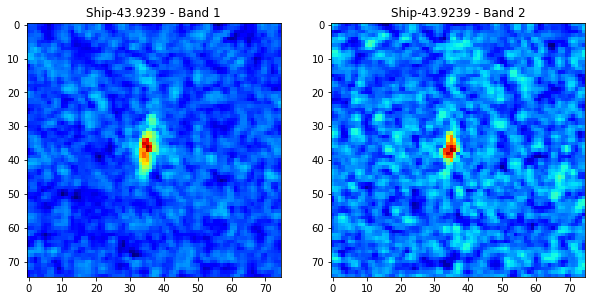

In [40]:
display_img(X_band_1[0], X_band_2[0], target_train[0], X_angle[0])

In [13]:
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.optimizers import rmsprop
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import plot_model

from keras.datasets import cifar10
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg19 import VGG19
from keras.layers import Concatenate, Dense, LSTM, Input, concatenate
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

#Data Aug for multi-input
from keras.preprocessing.image import ImageDataGenerator

In [14]:
def getSimpleCnnModel(input_tensor=None, angle_input = None, inner_index = 0):
    finalName = "final" if inner_index == 0 else ("final_" + str(inner_index))
    #Build keras model
    if angle_input is None:
        angle_input = Input(shape=[1], name="angle")
    angle_layer = Dense(1)(angle_input)
    if input_tensor is None:
        img_input = Input(shape=X_train.shape[1:], name="img")
    else:
        img_input = input_tensor
    
    # CNN 1
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(img_input)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 2
    x = Conv2D(128, kernel_size=(3, 3), activation='relu' )(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.2)(x)

    # CNN 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    #CNN 4
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)

    # You must flatten the data for the dense layers
    x = Flatten()(x)

    #Dense 1
    fc = Dense(512, activation='relu')(x)
    fc = Dropout(0.2)(fc)

    #Dense 2
    fc = Dense(256, activation='relu', name=finalName)(fc)
    fc = Dropout(0.2)(fc)
    
    #angle fuse
    fc = Concatenate()([fc, angle_layer])
                     
    # Output 
    predictions = Dense(1, activation="sigmoid")(fc)
    
    model = Model(inputs=[img_input, angle_input], outputs=predictions)
                     
    optimizer = Adam(lr=1e-3, decay=0.0)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [59]:
def getVggAngleModel():
    input_2 = Input(shape=[1], name="angle")
    angle_layer = Dense(1, )(input_2)
    base_model = VGG16(weights='imagenet', include_top=False, 
                 input_shape=X_train.shape[1:], classes=1)
    x = base_model.get_layer('block5_pool').output
    x = GlobalMaxPooling2D()(x)
    base_model2 = keras.applications.mobilenet.MobileNet(weights=None, alpha=0.9,input_tensor = base_model.input,include_top=False, input_shape=X_train.shape[1:])
    x2 = base_model2.output
    x2 = GlobalAveragePooling2D()(x2)
    
#     base_model3 = getSimpleCnnModel(input_tensor=base_model.input, angle_input=input_2)
#     x3 = base_model3.get_layer('final').output
    
#     base_model4 = getSimpleCnnModel(angle_input=input_2, inner_index = 2)
#     x4 = base_model4.get_layer('final_2').output

    merge_one = concatenate([x, x2, angle_layer])

    merge_one = Dropout(0.6)(merge_one)
    predictions = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(merge_one)
#     model = Model(inputs=[base_model.input, base_model4.input[0], input_2], outputs=predictions)
    model = Model(inputs=[base_model.input, input_2], outputs=predictions)
    
    sgd = Adam(lr=1e-4) 
#     sgd = SGD(lr=1e-4, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

In [16]:
model = getVggAngleModel()
model.summary()
plot_model(model, to_file="vgg_mobile.png")

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 75, 75, 3)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 38, 38, 28)    756         input_1[0][0]                    
____________________________________________________________________________________________________
conv1_bn (BatchNormalization)    (None, 38, 38, 28)    112         conv1[0][0]                      
____________________________________________________________________________________________________
conv1_relu (Activation)          (None, 38, 38, 28)    0           conv1_bn[0][0]                   
___________________________________________________________________________________________

In [82]:
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         channel_shift_range=0,
                         zoom_range = 0.5,
                         rotation_range = 15)

# Here is the function that merges our two generators
# We use the exact same generator with the same random seed for both the y and angle arrays
def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size, seed=55)
    genX2 = gen.flow(X1,X2, batch_size=batch_size, seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]

def gen_flow_for_three_inputs(X1, X2, X3, y):
    genX1 = gen.flow(X1,y,  batch_size=batch_size, seed=55)
    genX2 = gen.flow(X2,X3, batch_size=batch_size, seed=55)
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #Assert arrays are equal - this was for peace of mind, but slows down training
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[0], X2i[1]], X1i[1]

# Finally create generator
def get_callbacks(filepath, patience=2):
   #es = EarlyStopping('val_loss', patience=10, mode="min")
    es = EarlyStopping('val_loss', patience=20, mode="min")
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave, reduce_lr_loss]

In [102]:
def myAngleCV(X_train, X_angle, X_test):
    K=3
    folds = list(StratifiedKFold(n_splits=K, shuffle=True, random_state=16).split(X_train, target_train))
    y_test_pred_log = 0
    y_train_pred_log=0
    y_valid_pred_log = 0.0*target_train
    for j, (train_idx, test_idx) in enumerate(folds):
        print('\n===================FOLD=',j)
        X_train_cv = X_train[train_idx]
        # X_train_cv_2 = X_train_2[train_idx]
        y_train_cv = target_train[train_idx]
        X_holdout = X_train[test_idx]
        # X_holdout_2 = X_train_2[test_idx]
        Y_holdout= target_train[test_idx]
        
        # Angle
        X_angle_cv=X_angle[train_idx]
        X_angle_hold=X_angle[test_idx]
        
        # X_train_cv_input = [X_train_cv, X_train_cv_2, X_angle_cv]
        # X_train_val_input = [X_holdout, X_holdout_2, X_angle_hold]
        # X_train_input = [X_train, X_train_2, X_angle]
        # X_test_input = [X_test, X_test_2, X_test_angle]

        X_train_cv_input = [X_train_cv, X_angle_cv]
        X_train_val_input = [X_holdout, X_angle_hold]
        X_train_input = [X_train, X_angle]
        X_test_input = [X_test, X_test_angle]

        # define file path and get callbacks
        file_path = "%s_vgg_mobile_weights.hdf5"%j
        callbacks = get_callbacks(filepath=file_path, patience=10)
        # gen_flow = gen_flow_for_three_inputs(X_train_cv, X_train_cv_2, X_angle_cv, y_train_cv)
        X_train_cv = get_more_images(X_train_cv)
        X_angle_cv = np.concatenate([X_angle_cv, X_angle_cv, X_angle_cv, X_angle_cv])
        y_train_cv = np.concatenate([y_train_cv, y_train_cv, y_train_cv, y_train_cv])
        gen_flow = gen_flow_for_two_inputs(X_train_cv, X_angle_cv, y_train_cv)
        steps = np.ceil(len(X_train_cv) / batch_size)
        galaxyModel = getVggAngleModel()
        galaxyModel.fit_generator(
                gen_flow,
                steps_per_epoch=steps,
                epochs=150,
                shuffle=True,
                verbose=1,
                validation_data=(X_train_val_input, Y_holdout),
                callbacks=callbacks)

        # Getting the Best Model
        galaxyModel.load_weights(filepath=file_path)
        #Getting Training Score
        score = galaxyModel.evaluate(X_train_cv_input, y_train_cv, verbose=1)
        print('Train loss:', score[0])
        print('Train accuracy:', score[1])
        # Getting Test Score
        score = galaxyModel.evaluate(X_train_val_input, Y_holdout, verbose=1)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        # Getting validation Score.
        pred_valid=galaxyModel.predict(X_train_val_input, verbose=1)
        y_valid_pred_log[test_idx] = pred_valid.reshape(pred_valid.shape[0])

        # Getting Test Scores
        temp_test=galaxyModel.predict(X_test_input, verbose=1)
        y_test_pred_log+=temp_test.reshape(temp_test.shape[0])

        # Getting Train Scores
        temp_train=galaxyModel.predict(X_train_input, verbose=1)
        y_train_pred_log+=temp_train.reshape(temp_train.shape[0])

    y_test_pred_log=y_test_pred_log/K
    y_train_pred_log=y_train_pred_log/K

    print('\n Train Log Loss Validation= ',log_loss(target_train, y_train_pred_log))
    print(' Test Log Loss Validation= ',log_loss(target_train, y_valid_pred_log))
    return y_test_pred_log

In [ ]:
preds=myAngleCV(X_train, X_angle, X_test)


===================FOLD= 0
Epoch 1/150
67/67 [==============================] - 100s - loss: 0.8004 - acc: 0.5226 - val_loss: 0.6528 - val_acc: 0.6916
Epoch 2/150
67/67 [==============================] - 18s - loss: 0.7199 - acc: 0.5470 - val_loss: 0.6144 - val_acc: 0.7178
Epoch 3/150
67/67 [==============================] - 18s - loss: 0.6711 - acc: 0.6056 - val_loss: 0.5462 - val_acc: 0.7645
Epoch 4/150
67/67 [==============================] - 18s - loss: 0.6134 - acc: 0.6634 - val_loss: 0.5068 - val_acc: 0.7364
Epoch 5/150
67/67 [==============================] - 18s - loss: 0.5487 - acc: 0.7079 - val_loss: 0.3961 - val_acc: 0.8000
Epoch 6/150
67/67 [==============================] - 18s - loss: 0.4883 - acc: 0.7482 - val_loss: 0.3546 - val_acc: 0.8318
Epoch 7/150
67/67 [==============================] - 17s - loss: 0.4593 - acc: 0.7713 - val_loss: 0.3572 - val_acc: 0.8374
Epoch 8/150
67/67 [==============================] - 18s - loss: 0.4321 - acc: 0.7892 - val_loss: 0.3487 - val

In [ ]:
#Submission for each day.
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=preds
submission.to_csv('submission-vgg-mobilenet-plain.csv', index=False)

In [12]:
def display_img(band_1, band_2, is_iceberg, angle = None, confi = None):
    if angle is None:
        title_str = 'Iceberg' if is_iceberg == 1 else 'Ship'
    else:
        title_str = 'Iceberg-' + str(np.round(angle, 4)) if is_iceberg == 1 else 'Ship-' + str(np.round(angle, 4))
    if confi is not None:
        title_str += "-[confidence: " + str(np.round(confi, 4)) + "]"
    fig = plt.figure(0, figsize=(10,10))
    ax = fig.add_subplot(1,2,1)
    ax.set_title(title_str + ' - Band 1')
    ax.imshow(band_1,cmap='jet')
    ax = fig.add_subplot(1,2,2)
    ax.set_title(title_str + ' - Band 2')
    ax.imshow(band_2,cmap='jet')
    plt.show()
    
def apply_linear_lee_filter(band):
    return apply_lee_filter_single(decibel_to_linear(band))

def display_dataframe(df, index, preds=None, display_filtered = True):
    band_1 = np.array(df.iloc[index].band_1).astype(np.float32).reshape(75, 75)
    band_2 = np.array(df.iloc[index].band_2).astype(np.float32).reshape(75, 75)
    if "is_iceberg" in df.columns:
        is_iceberg = df.iloc[index].is_iceberg
    elif preds is not None:
        is_iceberg = np.round(preds[index])
    else:
        is_iceberg = None
    angle = df.iloc[index].inc_angle
    if preds is not None:
        display_img(band_1, band_2, is_iceberg, angle, preds[index])
    else:
        display_img(band_1, band_2, is_iceberg, angle)
    if display_filtered:
        display_img(apply_linear_lee_filter(band_1), apply_linear_lee_filter(band_2), is_iceberg, angle)

model = getVggAngleModel()
model.load_weights(filepath='0_vgg_mobile_weights.hdf5')

train_preds = model.predict([X_train, X_angle])
acc_score = accuracy_score(target_train, np.round(train_preds))
print("accuracy: ", acc_score)
print("mis num: ", (1 - acc_score) * target_train.shape[0])

In [13]:
wierd_data = pd.read_csv('submission-vgg-mobilenet-plain-0.2511-wierd.csv')
best_data = pd.read_csv('stack_minmax_bestbase-0.1451.csv')
wierd_data['round_is_iceberg'] = np.round(wierd_data.is_iceberg)
best_data['round_is_iceberg'] = np.round(best_data.is_iceberg)
if 'preds' not in locals():
    preds = wierd_data.is_iceberg
idx = np.where(wierd_data.round_is_iceberg != best_data.round_is_iceberg)[0]
for i in idx:
    print("index: ", i, "; is_iceberg: ", wierd_data.round_is_iceberg[i], best_data.round_is_iceberg[i])

index:  31 ; is_iceberg:  0.0 1.0
index:  44 ; is_iceberg:  0.0 1.0
index:  60 ; is_iceberg:  0.0 1.0
index:  70 ; is_iceberg:  0.0 1.0
index:  75 ; is_iceberg:  0.0 1.0
index:  76 ; is_iceberg:  0.0 1.0
index:  85 ; is_iceberg:  0.0 1.0
index:  101 ; is_iceberg:  0.0 1.0
index:  102 ; is_iceberg:  0.0 1.0
index:  104 ; is_iceberg:  0.0 1.0
index:  110 ; is_iceberg:  0.0 1.0
index:  117 ; is_iceberg:  0.0 1.0
index:  125 ; is_iceberg:  0.0 1.0
index:  130 ; is_iceberg:  0.0 1.0
index:  149 ; is_iceberg:  1.0 0.0
index:  151 ; is_iceberg:  0.0 1.0
index:  170 ; is_iceberg:  0.0 1.0
index:  180 ; is_iceberg:  0.0 1.0
index:  196 ; is_iceberg:  0.0 1.0
index:  210 ; is_iceberg:  0.0 1.0
index:  214 ; is_iceberg:  0.0 1.0
index:  228 ; is_iceberg:  0.0 1.0
index:  244 ; is_iceberg:  0.0 1.0
index:  263 ; is_iceberg:  0.0 1.0
index:  266 ; is_iceberg:  0.0 1.0
index:  280 ; is_iceberg:  0.0 1.0
index:  285 ; is_iceberg:  0.0 1.0
index:  290 ; is_iceberg:  1.0 0.0
index:  302 ; is_iceberg:  

index:  5925 ; is_iceberg:  0.0 1.0
index:  5939 ; is_iceberg:  0.0 1.0
index:  5946 ; is_iceberg:  0.0 1.0
index:  5947 ; is_iceberg:  1.0 0.0
index:  5948 ; is_iceberg:  0.0 1.0
index:  5949 ; is_iceberg:  0.0 1.0
index:  5959 ; is_iceberg:  0.0 1.0
index:  5974 ; is_iceberg:  0.0 1.0
index:  5979 ; is_iceberg:  0.0 1.0
index:  5994 ; is_iceberg:  0.0 1.0
index:  6011 ; is_iceberg:  1.0 0.0
index:  6017 ; is_iceberg:  1.0 0.0
index:  6027 ; is_iceberg:  0.0 1.0
index:  6038 ; is_iceberg:  0.0 1.0
index:  6039 ; is_iceberg:  0.0 1.0
index:  6043 ; is_iceberg:  0.0 1.0
index:  6047 ; is_iceberg:  0.0 1.0
index:  6057 ; is_iceberg:  0.0 1.0
index:  6062 ; is_iceberg:  0.0 1.0
index:  6065 ; is_iceberg:  0.0 1.0
index:  6068 ; is_iceberg:  0.0 1.0
index:  6071 ; is_iceberg:  0.0 1.0
index:  6072 ; is_iceberg:  0.0 1.0
index:  6085 ; is_iceberg:  0.0 1.0
index:  6090 ; is_iceberg:  1.0 0.0
index:  6092 ; is_iceberg:  1.0 0.0
index:  6096 ; is_iceberg:  1.0 0.0
index:  6104 ; is_iceberg:  

In [15]:
for i in idx:
    best_pred = best_data.iloc[i].is_iceberg
    wierd_pred = wierd_data.iloc[i].is_iceberg
    if abs(best_pred - 0.5) >= abs(wierd_pred - 0.5):
        print("use-best. ", i, best_pred, " --- ", wierd_pred)
    else:
        print("use_wierd. ", i, wierd_pred, " --- ", best_pred)

use_wierd.  31 0.000955503142904  ---  0.56655
use_wierd.  44 0.0180151108652  ---  0.778245
use_wierd.  60 2.04030275199e-05  ---  0.551965
use-best.  70 0.903733  ---  0.153029426932
use_wierd.  75 0.0659223422408  ---  0.561651
use-best.  76 0.769191  ---  0.32520416379
use-best.  85 0.827713  ---  0.401669710875
use_wierd.  101 0.000190428618225  ---  0.579608
use_wierd.  102 0.000138481627801  ---  0.566308
use_wierd.  104 0.00607364065945  ---  0.791832
use_wierd.  110 0.00293896324001  ---  0.502912
use_wierd.  117 0.271580457687  ---  0.713057
use-best.  125 0.783022  ---  0.474595934153
use_wierd.  130 4.85454838781e-05  ---  0.715369
use_wierd.  149 0.665235459805  ---  0.477236
use-best.  151 0.80176  ---  0.457716912031
use_wierd.  170 7.05946513335e-05  ---  0.58591
use_wierd.  180 0.175083324313  ---  0.557442
use_wierd.  196 0.15613745153  ---  0.739359
use_wierd.  210 0.367941647768  ---  0.550511
use_wierd.  214 0.0150357736275  ---  0.579664
use_wierd.  228 0.17691104

use_wierd.  1842 0.0149497203529  ---  0.73701
use_wierd.  1853 0.000390925066313  ---  0.511642
use_wierd.  1861 0.00779775017872  ---  0.556033
use_wierd.  1883 0.0415139682591  ---  0.59046
use-best.  1898 0.294673  ---  0.514452159405
use_wierd.  1909 0.165608122945  ---  0.650255
use_wierd.  1929 0.00259722443298  ---  0.591254
use_wierd.  1961 0.000441248557763  ---  0.612515
use_wierd.  1967 0.0339285843074  ---  0.778887
use_wierd.  1990 0.311277121305  ---  0.668606
use_wierd.  1992 0.0322284772992  ---  0.708055
use-best.  1997 0.397259  ---  0.545287430286
use_wierd.  2006 0.00117293780204  ---  0.729277
use_wierd.  2010 0.00125838862732  ---  0.571582
use_wierd.  2020 0.241711676121  ---  0.713817
use_wierd.  2025 0.683605909348  ---  0.393023
use_wierd.  2027 0.00323569774628  ---  0.669015
use_wierd.  2028 0.0525426082313  ---  0.757043
use_wierd.  2029 0.0063299224712  ---  0.54722
use_wierd.  2042 0.134553954005  ---  0.65254
use_wierd.  2046 0.227174416184  ---  0.5632

use_wierd.  4342 0.000697511190083  ---  0.816487
use_wierd.  4360 0.000605127541348  ---  0.537033
use_wierd.  4385 0.130662843585  ---  0.71495
use_wierd.  4402 1.77218189492e-05  ---  0.819141
use_wierd.  4407 0.986515820026  ---  0.209699
use-best.  4412 0.151042  ---  0.720677316189
use_wierd.  4416 0.149204298854  ---  0.55262
use_wierd.  4422 0.000355867581675  ---  0.555291
use_wierd.  4449 0.00218036887236  ---  0.677166
use_wierd.  4469 0.000390004832298  ---  0.668853
use_wierd.  4472 0.297729492188  ---  0.659155
use-best.  4476 0.606238  ---  0.402108520269
use_wierd.  4483 0.00325205805711  ---  0.57793
use_wierd.  4490 0.00177227298263  ---  0.873455
use_wierd.  4494 0.0805715397  ---  0.673595
use_wierd.  4497 0.00315757095814  ---  0.841735
use_wierd.  4501 0.000180477407412  ---  0.519765
use_wierd.  4503 0.00175267423037  ---  0.695042
use_wierd.  4512 0.0704383403063  ---  0.839813
use-best.  4516 0.798706  ---  0.360294491053
use-best.  4521 0.970227  ---  0.417856

use_wierd.  6597 0.000368051143596  ---  0.535758
use_wierd.  6598 1.92141233128e-05  ---  0.635328
use_wierd.  6609 7.18703304301e-05  ---  0.523046
use_wierd.  6623 1.82966914508e-06  ---  0.552617
use_wierd.  6624 0.142456367612  ---  0.667509
use_wierd.  6656 0.0606290735304  ---  0.692936
use_wierd.  6657 0.0144011145458  ---  0.690278
use_wierd.  6671 0.268968999386  ---  0.609644
use_wierd.  6681 7.6983757026e-05  ---  0.642473
use_wierd.  6697 0.884079158306  ---  0.277164
use_wierd.  6709 0.0300215985626  ---  0.660225
use-best.  6726 0.144754  ---  0.782256782055
use_wierd.  6731 0.0158127304167  ---  0.690473
use-best.  6744 0.997498  ---  0.384936094284
use_wierd.  6747 6.39553254587e-05  ---  0.575111
use_wierd.  6750 0.555765271187  ---  0.493071
use_wierd.  6752 0.000144515055581  ---  0.600867
use_wierd.  6759 1.99716741918e-05  ---  0.561072
use_wierd.  6765 0.0119385896251  ---  0.790615
use_wierd.  6773 0.0129040936008  ---  0.765581
use_wierd.  6782 0.00151152082253

In [54]:
# fues wierd data and cur best data 
_submission = pd.DataFrame()
_submission['id']=test['id']
_submission['is_iceberg']=preds

In [69]:
np.sum(np.round(_submission.is_iceberg) != np.round(best_data.is_iceberg))

0

In [71]:
print(_submission.is_iceberg.std(), _submission.is_iceberg.mean())
print(best_data.is_iceberg.std(), best_data.is_iceberg.mean())

0.405766858295 0.266616838612
0.381861455923 0.305709210826


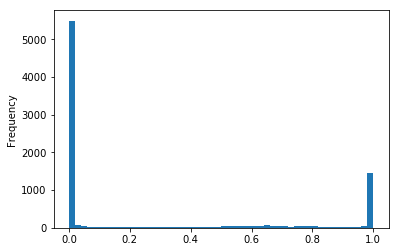

In [78]:
_submission.is_iceberg.plot.hist(bins=50)

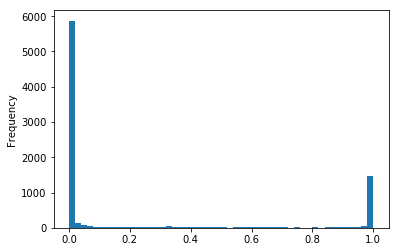

In [80]:
wierd_data.is_iceberg.plot.hist(bins=50)

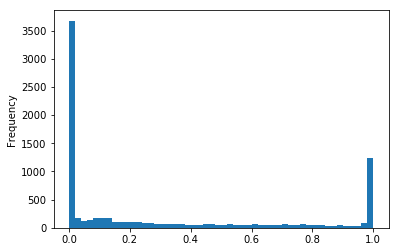

In [79]:
best_data.is_iceberg.plot.hist(bins=50)

In [95]:
print(np.sum(np.round(wierd_data.is_iceberg) == 0) / train.shape[0])

4.48606390211


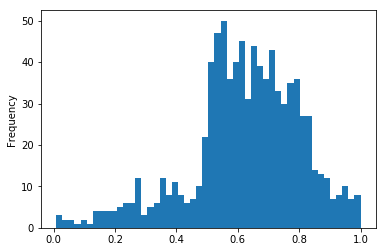

In [153]:
best_data.iloc[idx, 1].plot.hist(bins=50)

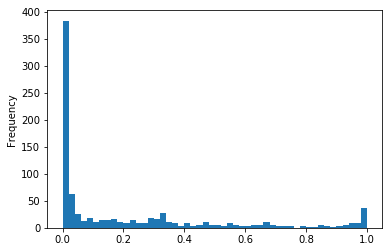

In [100]:
wierd_data.iloc[replace_idx, 1].plot.hist(bins=50)

In [137]:
train_band_1 = np.array([np.array(band) for band in train.band_1])
train_band_2 = np.array([np.array(band) for band in train.band_2])
test_band_1 = np.array([np.array(band) for band in test.band_1])
test_band_2 = np.array([np.array(band) for band in test.band_2])

train_mean_band_1 = np.mean(train_band_1, axis=0)
train_mean_band_2 = np.mean(train_band_2, axis=0)
test_mean_band_1 = np.mean(test_band_1, axis=0)
test_mean_band_2 = np.mean(test_band_2, axis=0)

In [141]:
print(train_band_1.std().mean(), test_band_1.std().mean(), train_mean_band_1.std())

5.21728697975 5.30792550425 1.33617664036


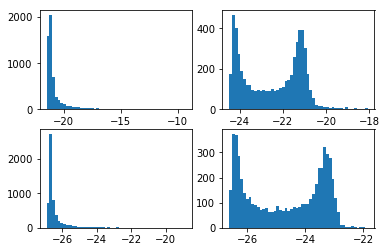

In [144]:
fig = plt.figure(1)
ax = fig.add_subplot(221)
ax.hist(train_mean_band_1, 50)
ax = fig.add_subplot(222)
ax.hist(test_mean_band_1, 50)
ax = fig.add_subplot(223)
ax.hist(train_mean_band_2, 50)
ax = fig.add_subplot(224)
ax.hist(test_mean_band_2, 50)
plt.show()

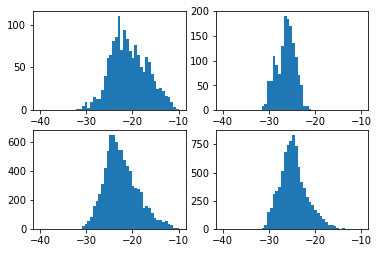

In [152]:
fig = plt.figure(2)
ax = fig.add_subplot(221)
ax.hist(train_band_1.mean(axis=1), 50, range=[-40, -10])
ax = fig.add_subplot(222)
ax.hist(train_band_2.mean(axis=1), 50, range=[-40, -10])
ax = fig.add_subplot(223)
ax.hist(test_band_1.mean(axis=1), 50, range=[-40, -10])
ax = fig.add_subplot(224)
ax.hist(test_band_2.mean(axis=1), 50, range=[-40, -10])
plt.show()

In [65]:
# fues wierd data and cur best data 
best_preds = best_data.iloc[idx].is_iceberg
wierd_preds = wierd_data.iloc[idx].is_iceberg
# replace_idx = idx[np.where(np.abs(best_preds - 0.5) >= np.abs(wierd_preds - 0.5))]
replace_idx = idx
_submission.iloc[replace_idx, 1] =  best_data.iloc[replace_idx, 1]

In [70]:
_submission.to_csv('submission-vgg-mobilenet-plain-wierd-_submission.csv', index=False)

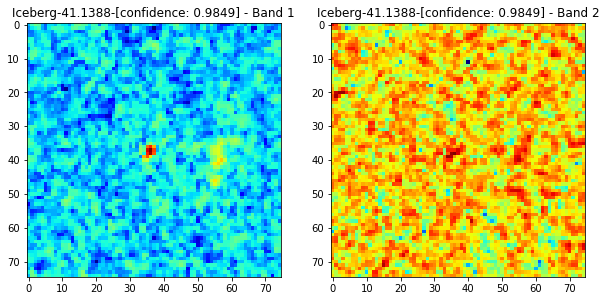

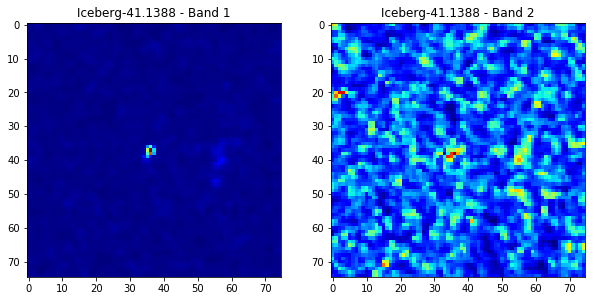

In [87]:
display_dataframe(test, 290, preds)
# display_dataframe(test, 44, preds)
# display_dataframe(test, 60, preds)
# display_dataframe(test, 70, preds)
# display_dataframe(test, 75, preds)